# Pruebas de bondad y ajuste

# Introducción

En las sesiones previas, hemos considerado diferentes familias de modelos que se puede usar como ingrediente clave para construir un simulador Monte Carlo. Aquí consideramos el lado cuantitativo de la moneda: después de *seleccionar una estructura de modelo*, **¿cómo debemos estimar sus parámetros?** Por lo tanto, entramos en el dominio de estadística inferencial, mediante la cual, dada una muestra de datos observados, participamos en tareas cada vez más difíciles: 
- Encontrar estimaciones de puntos e intervalos de momentos básicos como el valor esperado y varianza *(Pruebas de hipótesis e intervalos de confianza)*.
- Estimar los parámetros de una distribución de probabilidad posiblemente complicada
- Estimar los parámetros de un modelo de serie temporal

## Estadística inferencial básica

### 1. Intervalos de confianza

La mayoría de nosotros conoce las estadística inferencial mediante el cálculo de un intervalo de confianza para un valor esperado $\mu$. Este concepto es relevante en ambos extremos de una simulación Monte Carlo, ya que solía definir las variables aleatorias de entrada, así como analizar la salida. Dada una muestra $X_i, i = 1,. . . , n$ de i.i.d. variables aleatorias (independientes e idénticamente distribuidas), el simulacro es el siguiente:
1. Calcular la media y varianza de la muestra
$$ \bar X ={1\over n}\sum_{i=1}^nX_i,\qquad S^2={1\over n-1}\sum_{i=1}^n (X_i-\bar X )^2$$
2. Escoger un nivel de confianza $(1-\alpha)$ y tomar el correspondiente cuantil $t_{n-1,1-\alpha/2}$ de la distribución $t$ con $n-1$ grados de libertad.
3. Calcular el intervalo de confianza
$$\bar X \pm t_{n-1,1-\alpha/2}{S\over\sqrt{n}}$$

Este procedimiento es tan fácil de realizar que uno tiende a olvidar que se basa en algunas suposiciones importantes. Las siguientes observaciones están en orden:
- Estrictamente hablando, el procedimiento anterior es correcto solo para variables aleatorias normales. De hecho, si las variables $X_i \sim N (\mu, \sigma^2)$ son independientes, entonces es cierto que la siguiente estadística estandarizada es normal:
$$Z={\bar X -\mu \over \sigma/\sqrt{n}}\sim N\big(0,1\big)$$

Si nosotros reemplazamos $\sigma$ por su contraparte $S$, encontramos una distribución *$t$ student*
$$T={\bar X -\mu \over S/\sqrt{n}}\sim t_{n-1}, \qquad \qquad (1) $$
El cual implica
$$P\{-t_{n-1,1-\alpha/2}\leq T \leq t_{n-1,1-\alpha/2}\} = 1-\alpha$$

Al reordenar esta relación obtenemos el intervalo de confianza dado anteriormente. Una gran parte de las estadísticas inferenciales se basa en resultados de distribución similares. Si aplicamos el procedimiento a una **distribución diferente**, lo que encontramos es, en el mejor de los casos, una buena aproximación para una muestra **adecuadamente grande**; con una muestra pequeña y una distribución sesgada, deberíamos repetir el ejercicio para las características específicas de esa distribución.

- También es muy importante enfatizar el rol de la independencia. Es la independencia en la muestra lo que nos permite escribir
$$Var(\bar X)={\sigma^2 \over n}$$

- Al analizar el resultado de una simulación Monte Carlo, el tamaño de la muestra suele ser bastante grande. Por lo tanto, generalmente reemplazamos los cuantiles de la distribución $t$ con los cuantiles $z_{1-\alpha/2}$ de la distribución normal estándar. Sin embargo, esto no necesita aplicarse al análisis de datos de entrada.

In [1]:
import numpy as np
import scipy.stats as st     # Librería estadística
import matplotlib.pyplot as plt

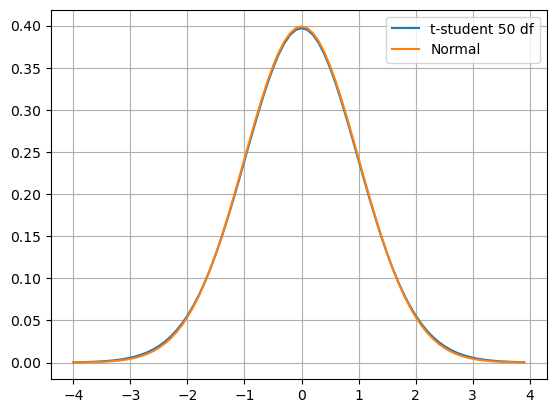

In [3]:
# Gráfica t-student
# %matplotlib inline
dat = np.arange(-4,4,.1)
# for i in range(1):
GL = 50
y = st.t.pdf(dat, df=GL)
y1 = st.norm.pdf(dat)
plt.plot(dat, y, label=f't-student {GL} df')
plt.plot(dat, y1, label='Normal')
plt.legend()
plt.grid()
plt.show()

# Intervalos de confianza en python

Utilizando la librería estadística `scipy.stats` y utilizando la función `t.interval(confianza, len(a)-1, loc=np.mean(a), scale=st.sem(a))`, se puede calcula un intervalo de confianza con un nivel de confianza definido en confianza, para un vector de entrada `a`. Se puede utilizar intervalos con los cuantiles de la normal estándar usando `st.norm.interval(confianza, loc=np.mean(a), scale=st.sem(a))`
> 1. [Definción de 'standar error of the mean'](https://www.investopedia.com/terms/s/standard-error.asp)
> 2. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html

In [18]:
np.random.seed(55555)
# Parámetros de los datos reales
media = 10
sd = 20
N = 1000
# Nivel de confianza
confianza = 0.95
# Datos reales
X = np.random.normal(media,sd,N)

# Ilustración de sem vs std
st.sem(X),np.std(X)/ np.sqrt(N)

(0.6338197205253959, 0.6335027313980297)

In [19]:
# Intervalo de confianza usando t-student
i1 = st.t.interval(confianza, len(X)-1, loc=np.mean(X), scale=st.sem(X))
# Intervalo de confianza usando distribución normal
i2 = st.norm.interval(confianza, loc=np.mean(X), scale=st.sem(X))
print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s     ' %(confianza,i1))
print('Con una confianza de %2.2f la media estará en el intervalo normal,\n %s' %(confianza,i2))
print('Media calculada' ,np.mean(X))

Con una confianza de 0.95 la media estará en el intervalo t,
 (8.17584847799572, 10.663389910937719)     
Con una confianza de 0.95 la media estará en el intervalo normal,
 (8.177355369545701, 10.661883019387737)
Media calculada 9.41961919446672


## 2. Pruebas de hipótesis

La prueba de hipótesis básica que uno puede desear ejecutar se refiere al valor esperado:
- Probamos la hipótesis nula Ho: $\mu = \mu_0$, para un $\mu_0$ dado,
- contra la hipótesis alternativa Ha: $\mu\neq \mu_0$

En el caso normal, confiamos en el resultado de distribución de Eq. (1), donde el valor esperado desconocido $\mu$ se reemplaza por el valor hipotético $\mu_0$. Esto muestra que, si la hipótesis nula es verdadera, entonces

$$P\bigg(-t_{n-1,1-\alpha/2}\leq {\bar X-\mu_0\over S/\sqrt n} \leq t_{n-1,1-\alpha/2}\bigg) = 1-\alpha$$

En otras palabras, todo se reduce a analizar el estadístico de prueba estandarizado
$$T={\bar X-\mu_0\over S/\sqrt n}$$

si la hipótesis nula es verdadera, tiene una distribución de t Student con n - 1 grados de libertad, y debe estar dentro de los límites correspondientes a los cuantiles. Si T cae fuera de ese intervalo, hay dos posibles explicaciones: puede ser simplemente mala suerte, o tal vez la hipótesis nula es incorrecta. No podemos estar seguros de ninguno de los dos, y podemos cometer dos tipos de error: **podemos rechazar una hipótesis verdadera, o podemos aceptar una falsa**. El enfoque elemental es conservador y mantiene la probabilidad de rechazar una verdadera hipótesis nula bajo control. Por lo tanto, formamos una región de rechazo que consta de dos colas

$$RJ = \{t:t<-t_{n-1,1-\alpha/2}\}\cup \{t:t>t_{n-1,1-\alpha/2}\}$$

Se rechaza la hipótesis nula si el estadístico $T\in RJ$. Acá $\alpha$ juega un papel de el nivel de significancia o mejor dicho, la probabilidad  de rechazar la hipótesis nula si esta es cierta. El valor típico para este nivel de significancia es tomarlo en 10%, 5% o 1%.

$$p-value= P(T)=P\bigg({\bar X -\mu_0 \over S/\sqrt n}\bigg)\sim t_{n-1}$$

La prueba mide si el puntaje promedio difiere significativamente entre las muestras. Si observamos un **valor de p grande**, por ejemplo mayor que 0.05 o 0.1, entonces **no podemos rechazar la hipótesis nula**. Si el valor p es menor que el umbral, p. 1%, 5% o 10%, luego rechazamos la hipótesis nula. Los pequeños valores p se asocian con grandes t-estadísticas.

In [20]:
# Hipótesis nula
media2 = 10
# Realizamos la prueba de hipotesis para H0= mu=media2
ho = st.ttest_1samp(X, media2)
print('La prueba de hipótesis arroja como resultado\n',ho)

La prueba de hipótesis arroja como resultado
 TtestResult(statistic=-0.9156875160845142, pvalue=0.36005179070146276, df=999)


In [21]:
# Calculamos el estadístico normalizado
t = (np.mean(X) - media2)/(np.std(X) / np.sqrt(N))
print('Cálculo del estadístico de prueba teórico=', t)

Cálculo del estadístico de prueba teórico= -0.916145703511778


In [22]:
# Cálculo de la región de rechazo
confianza_ph = 0.05
cuantil = st.t(N-1).cdf(1-confianza_ph/2)
print(f'Región de rechazo = (t<{-cuantil}) U (t>{cuantil})')

Región de rechazo = (t<-0.8351018568289704) U (t>0.8351018568289704)


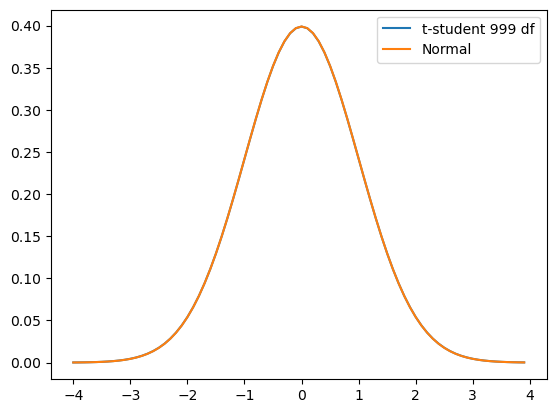

In [23]:
# Gráfica t-student
# %matplotlib inline
dat = np.arange(-4,4,.1)
# for i in range(1):
y = st.t.pdf(dat,df=N-1)
y1=st.norm.pdf(dat)
plt.plot(dat,y,label='t-student %d df' %(N-1))
plt.plot(dat,y1,label='Normal')
plt.legend()
plt.show()

> ### Mostrar el efecto de la cantidad de muestras en las pruebas de hipótesis

# Pruebas de bondad y ajuste



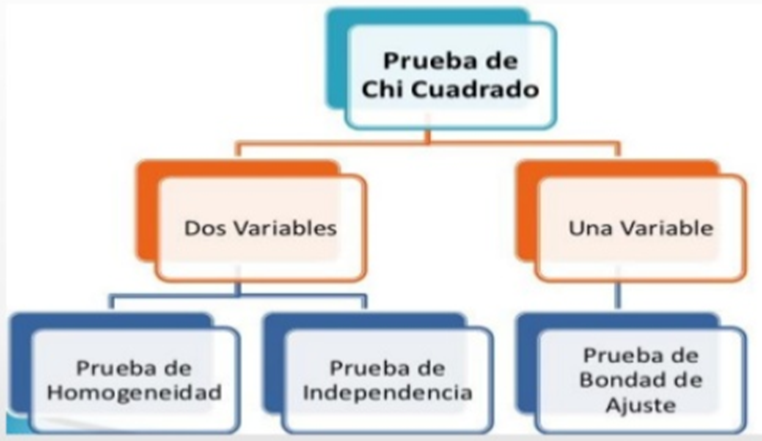

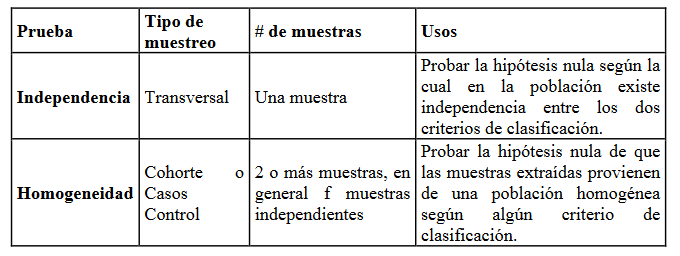

# Uso

- La prueba de chi-cuadrada nos permite probar si más de dos proporciones de población pueden ser consideradas iguales
- Además, si calificamos una población en diferentes categorías respecto a dos atributos (ej, edad y desempeño laboral), entonces podemos utilizarla para determinar si los dos atributos son independientes entre sí


# chi-cuadrada como prueba de independencia

Suponga que en 4 regiones de una compañía de salud muestra la actitud de los empleados respecto a la evaluación del desempeño en el trabajo. Los trabajadores eligen el método actual (2 por año) y el nuevo método (1 Trimestral)
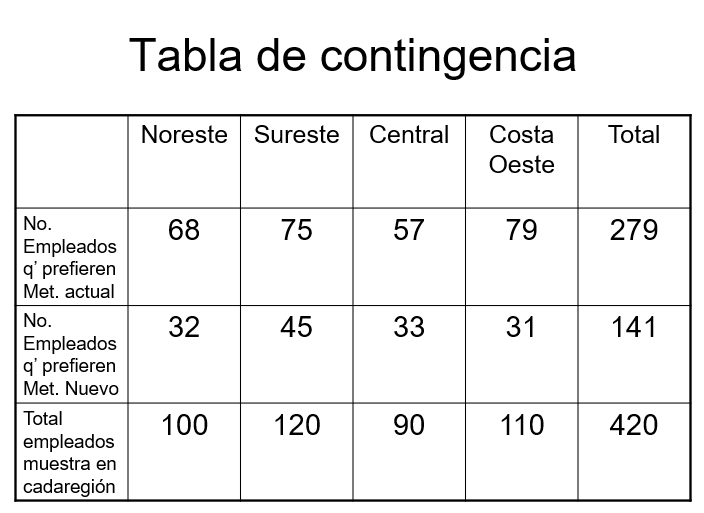

- La tabla anterior ilustra la respuesta a esta pregunta
- Las 4 columnas proporcionan una base de clasificación – regiones gráficas
- Los 2 renglones clasifican la información de otra manera: preferencia por los métodos de evaluación
- Tabla de contingencia de 2X4
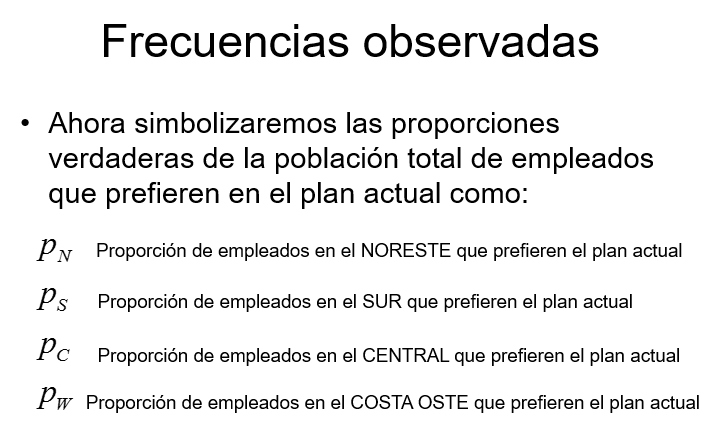

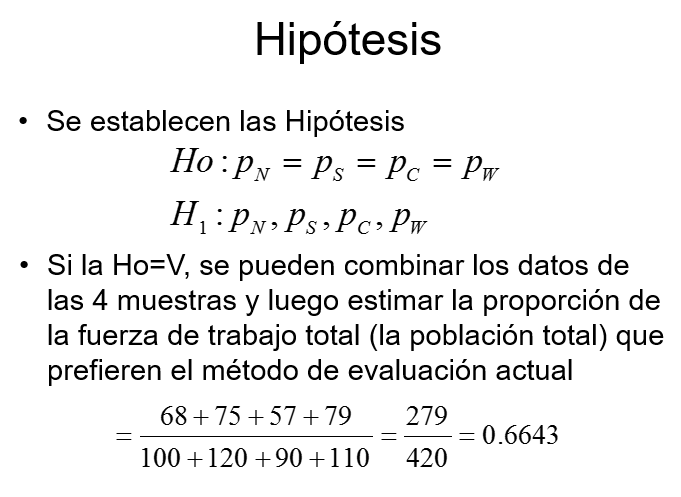

# Determinación de frecuencias esperadas

- Si el valor 0.6643 estima la proporción de población esperada que prefiere el método presente de evaluación, entonces 0.3357 es la estimación de la proporción esperada de la población que prefiere el nuevo método de evaluación, se puede estimar el número de empleados de la muestra de cada región que podríamos esperar que prefieran  cada uno de los métodos de evaluación
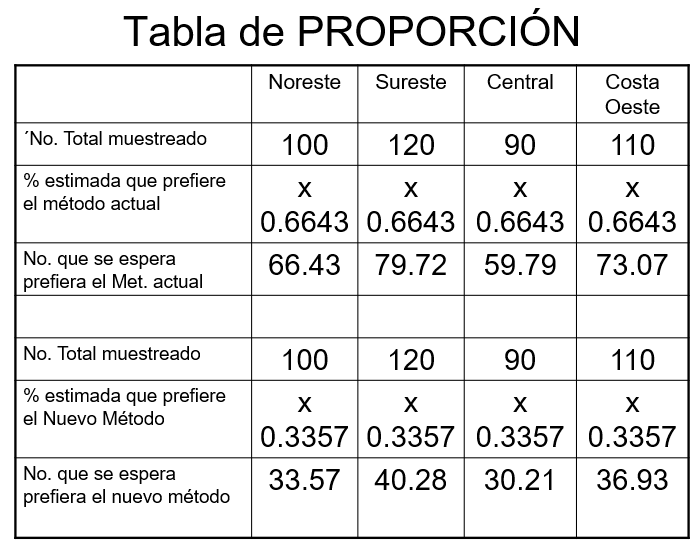

# Chi-cuadrada Razonamiento intuitivo

- En las tablas anteriores se ilustra las proporciones y frecuencias real y la teórica
- Para probar Ho se deben comparar las frecuencias que se observaron con las frecuencias que se esperaría si Ho=V
- Si los conjuntos de frecuencias observadas y esperadas son casi iguales, se puede razonar intuitivamente que  la Ho=v
- Si existe diferencias grandes entre estas frecuencias, podemos rechazar la Ho

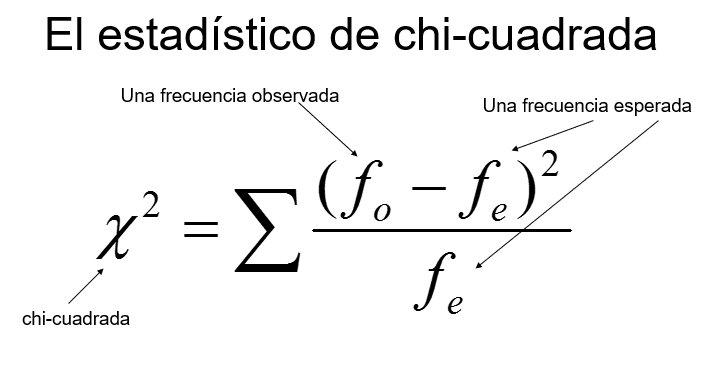

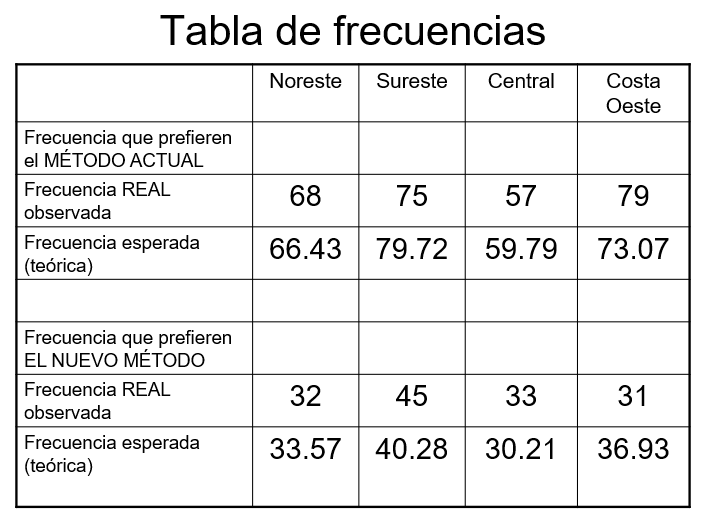

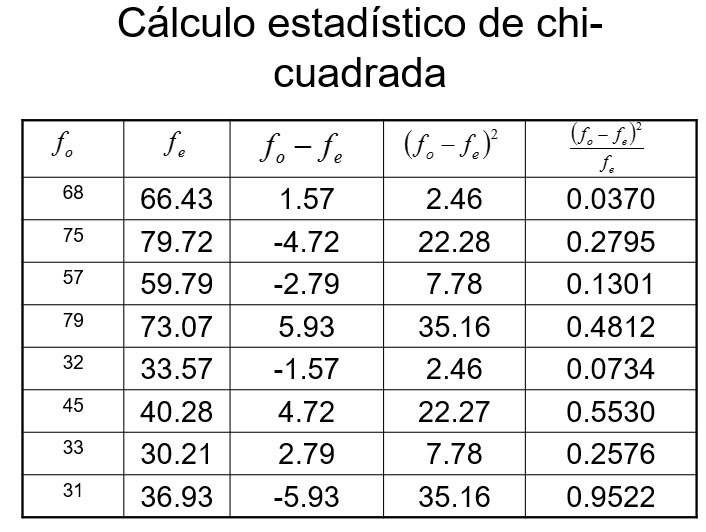

# Interpretación del cálculo
$$ \chi^2 = \sum \frac{(f_0-f_e)^2}{f_e}=2.764$$

- Este es el valor de chi-cuadrada en el problema de comparación de las preferencias de métodos de evaluación. Si este fuera muy grande, digamos 20, indicaría una diferencia sustancial entre valores reales y esperados.
- Una chi-cuadra=0 significa que los valores observados = valores reales
- chi-cuadrada nunca puede ser negativa


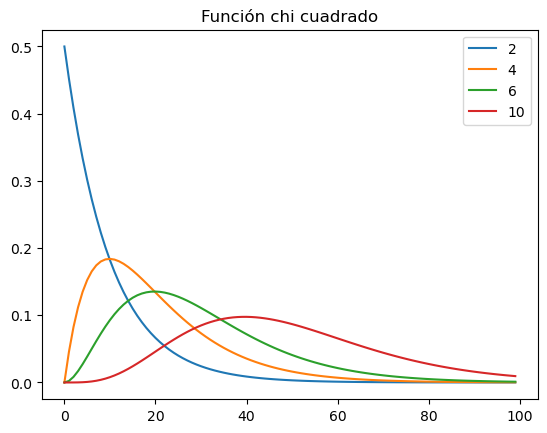

In [26]:
df = np.array([2,4,6,10])*1
x = np.linspace(0,2*max(df),100)
y = np.matrix(list(map(lambda df:st.chi2.pdf(x,df),df)))
plt.plot(y.T)
plt.legend(df)
plt.title('Función chi cuadrado')
plt.show()

# Descripción de distribución chi-cuadrada

- Si Ho=V, entonces la distribución de chi-cuadrada puede aproximarse bastante bien a una curva continua conocida con el mismo nombre(DJC)
- Existe una DJC por cada grado de libertad
- Para un número pequeño de GDL, la DJC está seriamente sesgada a la izquierda
- Al aumentar GDL se hace simétrica
- Si GDL es grande se asemeja a DNormal

# Determinación de los GDL

- GDL=(núm. Renglones – 1) (núm. Columnas - 1)
- En el ejercicio anterior GDL=(r-1)(c-1)=(2-1)(4-1)=3
 
- Si seleccionamos una nivel de significancia = 0.10
- Se calculo el estadístico de chi, con un nivel de significancia de  0.10 y 3GDL, lo cuál genera $$\text{Estadistico de chi}=6.251,$$ la región de aceptación de Ho va de la **cola izquierada de la curva al valor chi-cuadrada**
- El valor calculado de chi-cuadrada de la muestra es de $\chi_{stat}^2=2.764$ y cae dentro de la región de aceptación. Por lo tanto se acepta la Ho.
- P-value es la probabilidad de que un estadístico  chi-cuadrado con GDL grados de libertad sea más extrema que $\chi_{stat}^2$, es decir 
$$P-value = P(\chi^2>\chi_{stat}^2)$$
# Consideraciones con la utilización de datos recolectados
- Si el valor de chi-cuadrada fuera cero, tendríamos que ser cuidadosos al preguntar si no existe absolutamente ninguna diferencia entre las frecuencias observadas y las esperadas
- Es vital revisar si el sistema de muestreo fue el adecuado para validar o rechazar la Ho específica que se esta tratando

# Chi cuadrado en python

In [27]:
import pandas as pd

In [28]:
data = pd.DataFrame(index=['M_actual','M_nuevo','total_empleados'],columns=['noreste','sureste','central','costa_oeste','total'])
data.iloc[0,:-1] = [68,75,57,79]
data.iloc[1,:-1] = [32,45,33,31]
data['total'] = data.sum(axis=1)
data.loc['total_empleados',:] = data.sum(axis=0)

data

,noreste,sureste,central,costa_oeste,total
M_actual,68,75,57,79,279.0
M_nuevo,32,45,33,31,141.0
total_empleados,100,120,90,110,420.0


In [29]:
p = data.iloc[0, -1] / data.iloc[-1, -1]
f_e = np.concatenate([data.iloc[-1, 0:-1] * p, 
                data.iloc[-1, 0:-1] * (1 - p)])
f_o = data.iloc[0:2, 0:4].values.ravel()
f_o

array([68, 75, 57, 79, 32, 45, 33, 31], dtype=object)

In [46]:
# Calcular probabilidad asumiendo que la Ho se cumple
p = data.iloc[0, -1] / data.iloc[-1, -1]

# Obtener la frecuencia observada
f_o = data.iloc[0:2, 0:4].values.ravel()


# Calcular la frecuencia esperada
f_e = np.concatenate([data.iloc[-1, 0:-1] * p, 
                data.iloc[-1, 0:-1] * (1 - p)])

f_o, f_e

(array([68, 75, 57, 79, 32, 45, 33, 31], dtype=object),
 array([66.42857142857143, 79.71428571428571, 59.785714285714285,
        73.07142857142857, 33.57142857142858, 40.28571428571429,
        30.214285714285715, 36.92857142857143], dtype=object))

In [30]:
#### Método chi cuadrado
F_obse = f_o #[68,75,57,79,32,45,33,31]
F_espe = f_e #[66.43,79.72,59.79,73.07,33.57,40.28,30.21,36.93]

x2 = st.chisquare(F_obse, F_espe, ddof=3)
print('Valor de chi cuadrado = ',list(x2)[0],',p-value de la prueba=',list(x2)[1])

Valor de chi cuadrado =  2.7606330983132614 ,p-value de la prueba= 0.5986470620420181


In [31]:
Ji = st.chi2.ppf(q=0.9, df=3)
print('Estadístico de Ji = ',Ji)
# st.t.interval

Estadístico de Ji =  6.251388631170325


In [32]:
# p-value
x1 = st.chi2.cdf(list(x2)[0],df=3)
x1

0.5699785241068943

## Interpretación de resultados

Si los resultados de la muestra son poco probables, dada la hipótesis nula, el investigador rechaza la hipótesis nula. Por lo general, esto implica comparar el valor P con el nivel de significancia y **rechazar la hipótesis nula cuando el valor P es menor que el nivel de significancia.**

# Consideraciones de prueba chi cuadrado

## - Tamaños de muestras grandes
Para evitar incurrir en inferencias incorrectas de la prueba de Ho de chi-cuadrada, si la regla general de que una frecuencia esperada de menos de 5 en una celda de una tabla de contingencia, se considera **demasiado pequeña para utilizarse**

## - Utilización de datos recolectados
- Si el valor de chi-cuadrada fuera cero, tendríamos que ser cuidadosos al preguntar si no existe absolutamente ninguna diferencia entre las frecuencias observadas y las esperadas
- Es vital revisar si el sistema de muestreo fue el adecuado para validar o rechazar la Ho específica que se esta tratando


# Nota:
Cuándo usar la prueba de chi-cuadrado para la independencia

El procedimiento de prueba descrito en esta lección es apropiado cuando se cumplen las siguientes condiciones:

- El método de muestreo es un muestreo aleatorio simple.
- Las variables en estudio son cada una categórica.
- Si los datos de muestra se muestran en una tabla de contingencia, el recuento de frecuencia esperado para cada celda de la tabla es al menos 5.

# Ejercicio
Para ver si la venta de chips de silicio son independientes del punto del ciclo de negocios en que se encuentre la economía del país se han recogido las ventas semanales de una empresa y datos acerca de la economía del país, y se reportan los siguientes resultados:
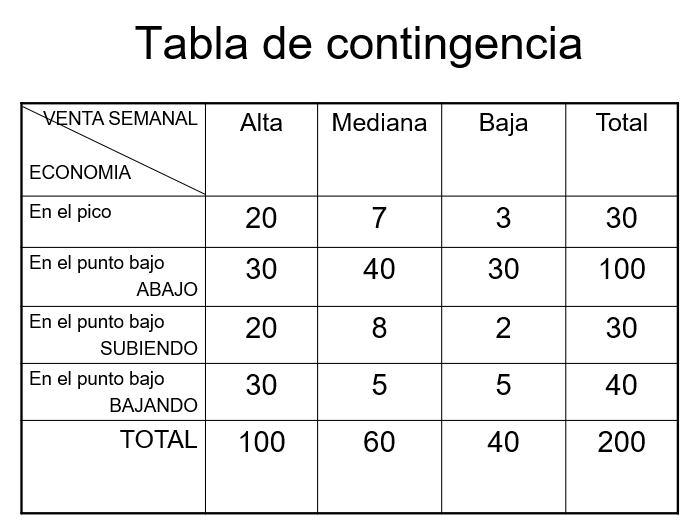

Realice la prueba de chi-cuadrado para validar la independencia del punto del ciclo de negocios en que se encuentre la economía.

> Ver en este enlace la forma de probar independencia: https://stattrek.com/chi-square-test/independence.aspx?Tutorial=AP
Del enlace anterior replicar los resultados reportados de `Homogeneidad` y `prueba de bondad y ajuste` en python. De esta manera entender cómo se deben realizar estas dos pruebas adicionales.
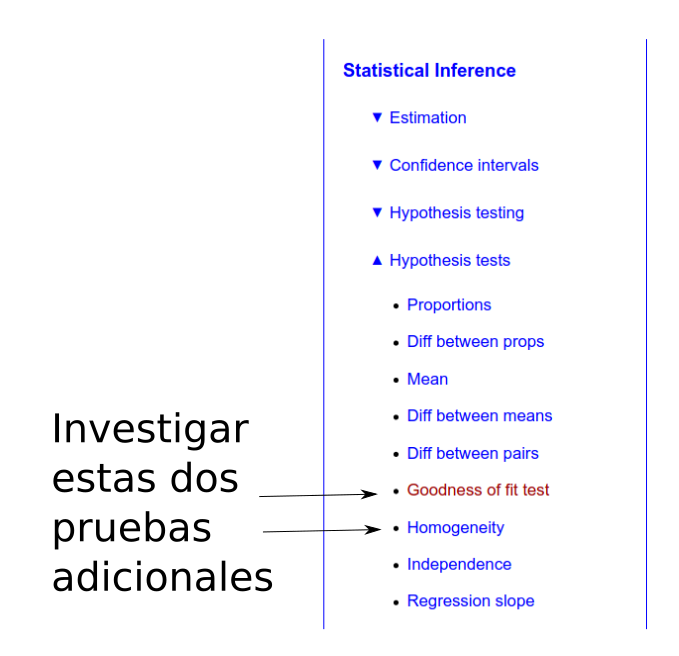

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>